Optional: Importing trained weights from previous training

In [ ]:
import tensorflow as tf
from google.colab import drive
# Mounting to access prior weights and data
drive.mount('/content/drive')

# Open previous model
!ls saved_model
!ls /content/drive/MyDrive/test_folder

new_model = tf.keras.models.load_model('/content/drive/MyDrive/test_folder')
new_model.summary()

ls: cannot access 'saved_model': No such file or directory
assets	keras_metadata.pb  saved_model.pb  variables
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pool

Building model

In [ ]:
import tensorflow as tf 
from keras import models, layers 
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = (495, 619)
BATCH_SIZE = 32
SEED = 42
path = '/content/drive/MyDrive/Datasets/mri_images'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/mri_images/Training",
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = 42
)
class_names = dataset.class_names

# Check
print(class_names)
print(len(dataset))

Found 2870 files belonging to 4 classes.
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
90


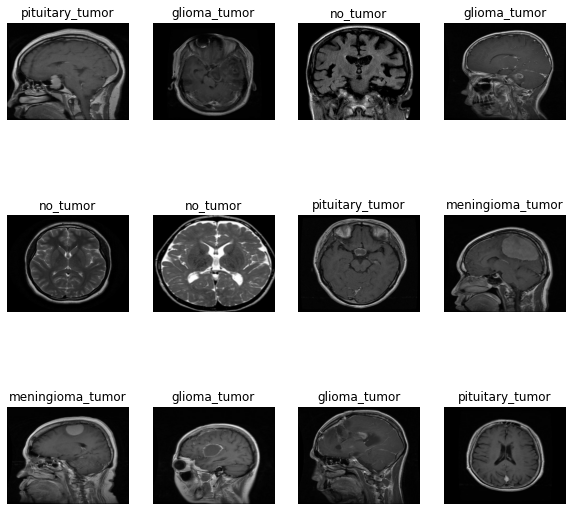

In [ ]:
# visualizing
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
# Spitting training dataset for 10% validation 
# print(len(dataset))
# print(0.90 * 90)

train_ds = dataset.take(81) # functions as [:85]
val_ds = dataset.skip(81)   # functions as [85:]

def split_ds(ds, train_split = 0.9, val_split = 0.10, shuffle=True, shuffle_size=(10000)):
  ds_size = len(ds)
  
  if shuffle:
    ds.shuffle(shuffle_size, seed=SEED)

  # Calculating where to split
  train_size = int(train_split * ds_size) 
  val_size   = int(val_split * ds_size)   

  # Spltting
  train_ds = ds.take(train_size)              # [:85] on the dataset
  val_ds = ds.take(val_size)                  # [85:] on the dataset

  # if you dont have a training dataset 
  # train_ds = ds.take(train_size)
  # val_ds   = ds.skip(train_size).take(val_size) 
  # test_ds  = ds.skip(train_size).skip(val_size) 

  return train_ds, val_ds

In [ ]:
train_ds, val_ds = split_ds(dataset)

# Caching and prefetching for speed 
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 495, 619, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomZoom(height_factor=(0, 0.1), width_factor=(0, 0.1)),
    tf.keras.layers.Rescaling(1./255)
])

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=SEED),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical",seed=SEED)
])

In [ ]:
INPUT_SHAPE = (BATCH_SIZE, 224, 224, 3)
model = tf.keras.Sequential([
    resize_rescale,
    augmentation,                                
])

model.build(input_shape=INPUT_SHAPE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
INPUT_SHAPE = (BATCH_SIZE, 495, 619, 3)
model = tf.keras.Sequential([
    resize_rescale,
    augmentation, 
    # 32 as a filter size and (3, 3) as kernel size is gathered through trial and error 
    layers.Conv2D(32, (3, 3), padding="same", input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='sigmoid')
])

model.build(input_shape=INPUT_SHAPE)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [ ]:
EPOCHS = 30

model.compile(
    optimizer='Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30


81/81 [==============================] - 394s 5s/step - loss: 1.1762 - accuracy: 0.4981 - val_loss: 1.0848 - val_accuracy: 0.4931
Epoch 2/30
81/81 [==============================] - 349s 4s/step - loss: 0.9239 - accuracy: 0.6169 - val_loss: 0.8748 - val_accuracy: 0.6111
Epoch 3/30
81/81 [==============================] - 365s 4s/step - loss: 0.7626 - accuracy: 0.6852 - val_loss: 0.8271 - val_accuracy: 0.6667
Epoch 4/30
81/81 [==============================] - 360s 4s/step - loss: 0.6648 - accuracy: 0.7299 - val_loss: 0.9233 - val_accuracy: 0.6250
Epoch 5/30
81/81 [==============================] - 361s 4s/step - loss: 0.6254 - accuracy: 0.7477 - val_loss: 0.7662 - val_accuracy: 0.6736
Epoch 6/30
81/81 [==============================] - 356s 4s/step - loss: 0.5522 - accuracy: 0.7747 - val_loss: 0.5852 - val_accuracy: 0.7917
Epoch 7/30
81/81 [==============================] - 356s 4s/step - loss: 0.5073 - accuracy: 0.8009 - val_loss: 0.8492 - val_accuracy: 0.6736
Epoch 8/30
81/81 [======

In [ ]:
# saving weights 
!mkdir -p saved_model
model.save('/content/drive/MyDrive/test_folder') 

In [ ]:
accuracy      = history.history["accuracy"]
val_accuracy = history.history['val_accuracy']
loss         = history.history['loss']
val_loss     = history.history['val_loss']

len(val_accuracy), len(accuracy)

(20, 20)

Text(0.5, 1.0, 'Training and Validation Loss')

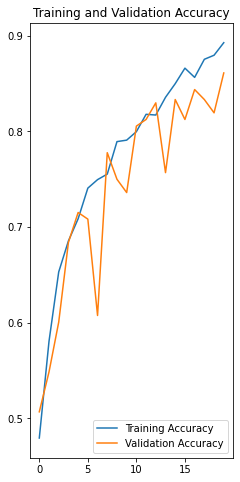

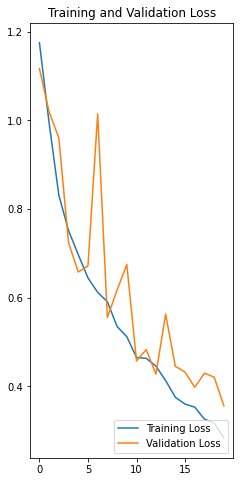

In [ ]:
# visualizing accuracy and loss 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), accuracy, label = 'Training Accuracy')
plt.plot(range(20), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), loss, label = 'Training Loss')
plt.plot(range(20), val_loss, label = 'Validation Loss ')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

Image to predict
Actualy Label: pituitary_tumor
1/1 [==============================] - 1s 671ms/step
Predicted Label: pituitary_tumor


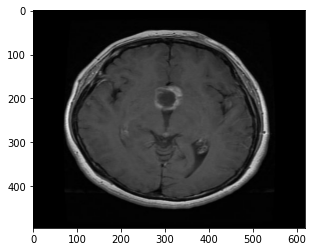

In [ ]:
import numpy as np
# Self validation image set prediction
for image_batch, labels_batch in val_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('Image to predict')
  plt.imshow(first_image)
  print("Actualy Label:", class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])



1/1 [==============================] - 0s 117ms/step


('I predict you have: no_tumor with 0.8899999856948853 certainty',)

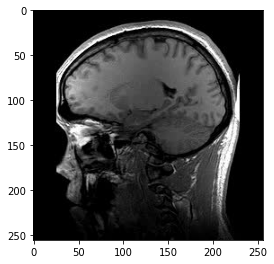

In [ ]:
# Own image prediction
import cv2
def predict(model, image):
  image = cv2.imread(image)

  # visualization
  plt.figure(figsize = (14, 14))
  img = plt.subplot2grid((1,3),(0,2))
  img.imshow(image)

  # making prediction
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  image_array   = tf.expand_dims(image_array, 0)

  prediction = model.predict(image_array)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(np.max(prediction[0]), 2)
  return f"I predict you have: {predicted_class} with {confidence} certainty", 

predict(model, '/content/256px--Structural_MRI_animation.ogv.jpg')
